In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

In [2]:
import matplotlib.pyplot as plt
import numpy as np

## Importing the MNIST dataset

based on the following pytorch excercise by Udacity: (Lesson 5.9 of [this](https://www.udacity.com/course/deep-learning-pytorch--ud188) course)

    Part 3 - Training Neural Networks (Exercises)


In [3]:
# define a transform 
# for this we need to convert the input to torch-tensors using transforms.ToTensor()
# we will be working with MNIST dataset which are gray scale images
# V.Imp: Since the MNIST images have a  single channel, therefore one might be tempted to 
# call transforms.Normalize((0.5), (0.5)) instead of transforms.Normalize((0.5,), (0.5,))
# The difference is the presence of a comma after 0.5 in the second call
# then this will throw an error "too many indices for tensor of dimension 0"
# this is because transforms.Normalize wants a tuple to be passed as its mean and standard
# however torch interprets (0.5) as a number and NOT a tuple. So we need to pass (0.5, )
# This is well explained by Berriel in the following stackoverflow post
# https://stackoverflow.com/questions/56745486/pytorch-dataloader-indexerror-too-many-indices-for-tensor-of-dimension-0

transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5, ), (0.5, ))]) 

# import the MNIST dataset
train = datasets.MNIST('~/.pytorch/MNIST_data/', download = True, train = True, transform = transform)
# Dataloader
trainloader = torch.utils.data.DataLoader(train, batch_size = 128, shuffle = True)

Each image has shape: (28, 28)


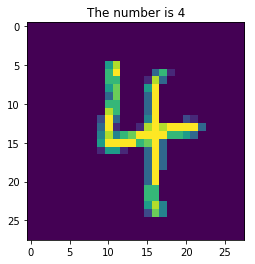

In [4]:
# checkout a random image in the training set
image, label = next(iter(trainloader))
img=torch.squeeze(image[0],0).numpy()
print('Each image has shape: {}'.format(img.shape))
plt.figure()
plt.imshow(img)
plt.title("The number is {}".format(label[0]))
plt.show()

## Defining a simple CNN 

In [5]:
# model architechture:
# 1st Conv. layer with 4 filters; Each having a kernel of size 3, stride = 1, and default padding and dilation
# this will reduce the shape of the input tensor from (1,28,28) to (4,26,26)
# then apply Relu activation
# 2nd Conv. layer with 2 filters, each having a kernel size 5, stride = 1, default padding and dilation
# the output of this layer will have shape (2, 22, 22)
# again apply ReLU to this output
# Now flatten the output to pass to a linear NN for classification
# The output of this layer will be a 1d array of 2*22*22 = 968 elements
# We now add a linear layer of 32 nuerons

# the model has to be a class that inherits from nn.Module
# note that we can define relu once and use it repeatedly. Also see the following discussion
# https://discuss.pytorch.org/t/using-same-dropout-object-for-multiple-drop-out-layers/39027
class my_CNN(nn.Module):
    # class constructor (i.e. initializer)
    def __init__(self):
        # initialize the base class
        super().__init__()
        
        self.l1 = nn.Conv2d(1, 4, 3 )
        
        self.relu = nn.ReLU()
        
        self.l2 = nn.Conv2d(4, 2, 5 )
        
        self.flatten = nn.Flatten()
        
        self.l3 = nn.Linear(968, 32, bias = True)
        
        self.l4 = nn.Linear(32, 10, bias = True)
        
        self.logsoftmax = nn.LogSoftmax(dim=1) # we need to apply LogSoftmax if the loss function is NLLLoss
        
    def forward(self, x):
        out1 = self.l1(x)
        act1 = self.relu(out1)
        out2 = self.l2(act1)
        act2 = self.relu(out2)
        flat = self.flatten(act2)
        out3 = self.l3(flat)
        act3 = self.relu(out3)
        out4 = self.l4(act3)
        
        output = self.logsoftmax(out4)
        
        return output
        
        
        
        

In [6]:
model = my_CNN()
model

my_CNN(
  (l1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU()
  (l2): Conv2d(4, 2, kernel_size=(5, 5), stride=(1, 1))
  (flatten): Flatten()
  (l3): Linear(in_features=968, out_features=32, bias=True)
  (l4): Linear(in_features=32, out_features=10, bias=True)
  (logsoftmax): LogSoftmax()
)

In [7]:
out = model(image)

In [8]:
out.shape

torch.Size([128, 10])

In [9]:
# defining loss and optimizer
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

## Untrained Predictions

loss on untrained model is: 2.318549156188965


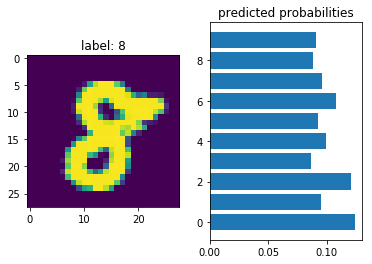

In [10]:
images, labels = next(iter(trainloader))

with torch.no_grad():
    pred_untrained = model(images) # recall that these are obtained from LogSoftmax()
    loss_untrained = criterion(pred_untrained, labels)
    print('loss on untrained model is: {}'.format(loss_untrained))

    
# display the untrained predicitons for a random image
randidx = np.random.randint(0, images.shape[0])
img = images[randidx].squeeze(0).numpy()
pred_prob = torch.exp(pred_untrained[randidx]) # pred_untrained is the log of the probability 
                                              # this is due to the last layer of the model being LogSoftmax
                                            
# See the following post for some discussion on making subplots
# https://stackoverflow.com/questions/14770735/how-do-i-change-the-figure-size-with-subplots
fig, (ax1, ax2) = plt.subplots(ncols = 2) 
ax1.imshow(img)
ax1.set_title('label: {}'.format(labels[randidx]))
ax2.barh(np.arange(10), pred_prob)
ax2.set_title('predicted probabilities')
plt.show()

## Training the model

In [11]:
# training
epochs = 10
losses = []
for epoch in range(epochs):
    running_loss = 0
    
    for images, labels in trainloader:
        optimizer.zero_grad()
        predprob = model(images)
        loss = criterion(predprob, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() 
    
    losses.append(running_loss/len(trainloader)) # this is the average loss per batch
    print('average loss per batch at the end of epoch: {} is {}'.format(epoch, losses[-1]))              
    

average loss per batch at the end of epoch: 0 is 0.3947143161506541
average loss per batch at the end of epoch: 1 is 0.12875364558783167
average loss per batch at the end of epoch: 2 is 0.09219098247206414
average loss per batch at the end of epoch: 3 is 0.07619809164111611
average loss per batch at the end of epoch: 4 is 0.06473747259780352
average loss per batch at the end of epoch: 5 is 0.057744919696747304
average loss per batch at the end of epoch: 6 is 0.051055579738163236
average loss per batch at the end of epoch: 7 is 0.04623946428759647
average loss per batch at the end of epoch: 8 is 0.04135425255270496
average loss per batch at the end of epoch: 9 is 0.038347231019149296


model prediction: 2
image label: 2


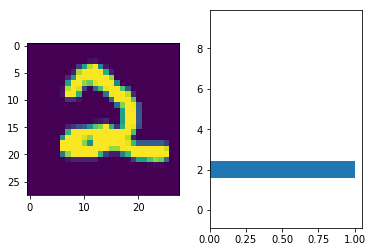

In [12]:
# verify model predictions
images, labels = next(iter(trainloader))
with torch.no_grad():
    preds = model(images)

    img = torch.squeeze(images[0]).numpy()
    prd = torch.argmax(preds[0]).item()
    lbl = labels[0].item()
    print('model prediction: {}'.format(prd))
    print('image label: {}'.format(lbl))
    
    # Display the figure and prediction probabilites
    fig, ax = plt.subplots(ncols = 2)
    ax[0].imshow(img)
    ax[1].barh(np.arange(10), torch.exp(preds[0]))
    plt.show()

# Forward Hook to visualize the layer outputs

In [13]:
# visualizing CNN features
# see https://discuss.pytorch.org/t/visualize-feature-map/29597/2
# and https://blog.paperspace.com/pytorch-hooks-gradient-clipping-debugging/
activation = {}
def get_activation(name):
    def hook(m, i , o):
        
        # m is the module/layer
        # i is the input to the layer
        # o is the output of the layer
        activation[name] = o.detach()
    
    return hook


model.l1.register_forward_hook(get_activation('l1'))
model.l2.register_forward_hook(get_activation('l2'))

In [14]:
img, label = next(iter(trainloader))

# uncomment the following lines if you want to pass only a single image through model instead of an entire batch
# img = train[0]
#img.unsqueeze_(0) # input to the model is a 4d tensor with the zeroth axis being the batch index
                  # we therefore need to unsqueeze to reshape our image into a 4d tensor
print(img.shape)
output = model(img)

torch.Size([128, 1, 28, 28])


### output of layer 1

In [15]:
activation['l1'].shape #This seems to have the shape: batch_size, num_neurons, output_height, output_width

torch.Size([128, 4, 26, 26])

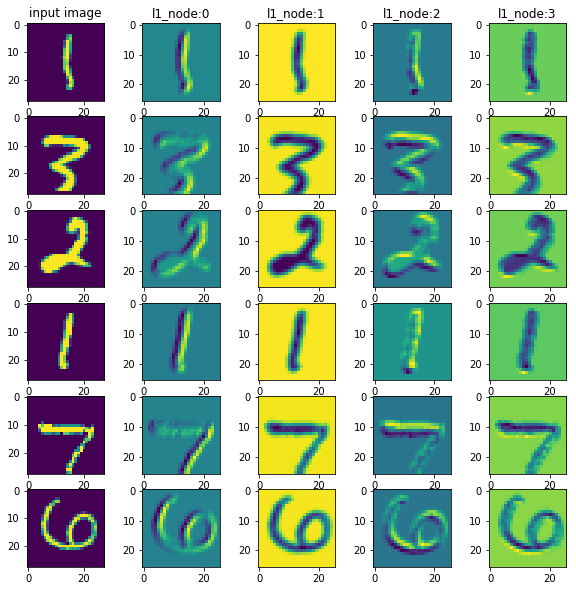

In [16]:
num_neurons1 = activation['l1'].shape[1]
nrows = 6 # number of rows in the figure
ncols = num_neurons1+1 # number of columns in the figure

fig, ax = plt.subplots(figsize= (10,10), nrows = nrows, ncols = ncols )
for row_itr in range(nrows): 
    ax[row_itr, 0].imshow(img[row_itr,0])
    
    for col_itr in range(1,ncols):
        ax[row_itr, col_itr].imshow(activation['l1'][row_itr,col_itr-1].numpy())
    
ax[0, 0].set_title('input image')
ax[0, 1].set_title('l1_node:{}'.format(0))
ax[0, 2].set_title('l1_node:{}'.format(1))
ax[0, 3].set_title('l1_node:{}'.format(2))
ax[0, 4].set_title('l1_node:{}'.format(3))
plt.show()    
    


From the figure above, we see that the feature maps in the first convolution layer seem to get most activated according to the following rules:

   - l1_node 0: by vertical lines in the input image
   - l1_node 1: by pixels with low values i.e. this node seems to invert the pixel values of the input image
   - l1_node 2: by horizontal in the input image
   - l1_node 3: This seems to get most strongly activated by horizontal edges that have darker pixels below them and brighter pixels above them. 

### output of layer 2

In [17]:
activation['l2'].shape

torch.Size([128, 2, 22, 22])

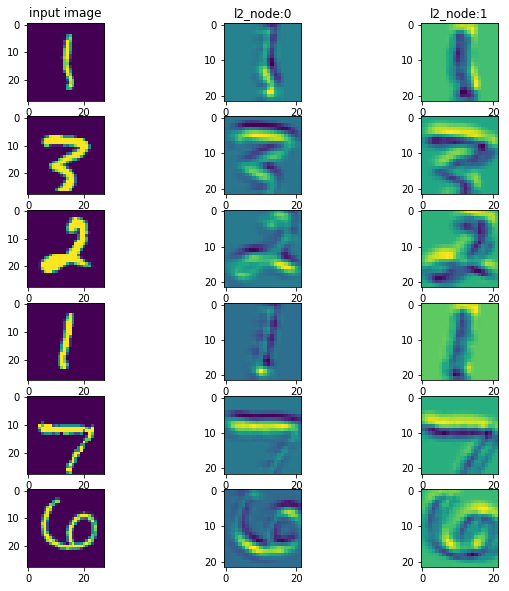

In [18]:
num_neurons2 = activation['l2'].shape[1]
nrows = 6
ncols = num_neurons2+1

fig, ax = plt.subplots(figsize = (10,10), nrows = nrows, ncols = ncols )
for row_itr in range(nrows): 
    ax[row_itr, 0].imshow(img[row_itr,0])
    
    for col_itr in range(1,ncols):
        ax[row_itr, col_itr].imshow(activation['l2'][row_itr,col_itr-1].numpy())
    
ax[0, 0].set_title('input image')
ax[0, 1].set_title('l2_node:{}'.format(0))
ax[0, 2].set_title('l2_node:{}'.format(1))
plt.show()  

 From the above figure we can infer the following about the feature maps in the second convolution layer 
 - l2_node 0: this seems to get most strongly activated by horizontal lines in the input image
 - l2_node 1: this seems to get most strongly activated by horizontal edges that have brighter pixels below them and darker pixels above them.

## Alternate: Getting layer outputs without using hooks

We can also access the individual layers of a model by using model._modules 

In [19]:
layers_list = list(model._modules.items())
print('length of layers_list: {}'.format(len(layers_list)))

length of layers_list: 7


In [20]:
layers_list

[('l1', Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))),
 ('relu', ReLU()),
 ('l2', Conv2d(4, 2, kernel_size=(5, 5), stride=(1, 1))),
 ('flatten', Flatten()),
 ('l3', Linear(in_features=968, out_features=32, bias=True)),
 ('l4', Linear(in_features=32, out_features=10, bias=True)),
 ('logsoftmax', LogSoftmax())]

### output of layer 1

In [21]:
conv1 = layers_list[0][1]
conv1

Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))

In [22]:
conv1_out = conv1(img).detach().clone()

In [23]:
conv1_out.shape

torch.Size([128, 4, 26, 26])

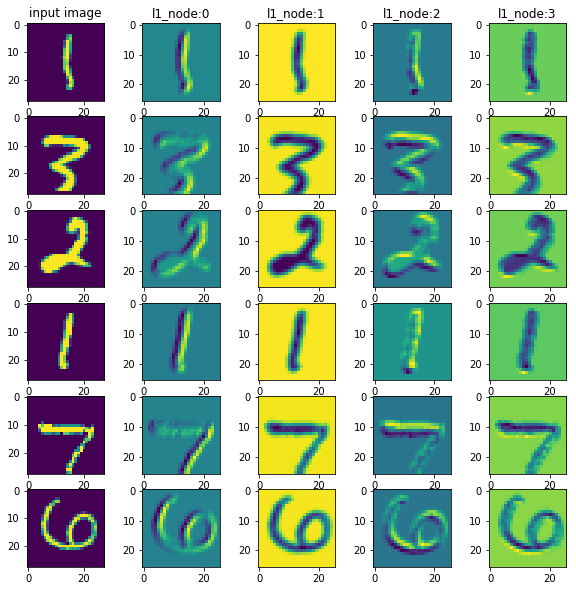

In [24]:
num_neurons1 = conv1_out.shape[1]
nrows = 6
ncols = num_neurons1+1
fig, ax = plt.subplots(figsize=(10,10), nrows = nrows, ncols = ncols )
for row_itr in range(nrows): 
    ax[row_itr, 0].imshow(img[row_itr,0])
    
    for col_itr in range(1,ncols):
        ax[row_itr, col_itr].imshow(conv1_out[row_itr,col_itr-1].numpy())
    
ax[0, 0].set_title('input image')
ax[0, 1].set_title('l1_node:{}'.format(0))
ax[0, 2].set_title('l1_node:{}'.format(1))
ax[0, 3].set_title('l1_node:{}'.format(2))
ax[0, 4].set_title('l1_node:{}'.format(3))
plt.show()  

The output above looks exactly the same as that we got for layer1 using hooks

### output of layer 2

In [25]:
conv2 = layers_list[2][1]
conv2

Conv2d(4, 2, kernel_size=(5, 5), stride=(1, 1))

In [26]:
conv2_out = conv2(F.relu(conv1_out)).detach().clone() # input of l2 is obtained from applying relu to the output of l1

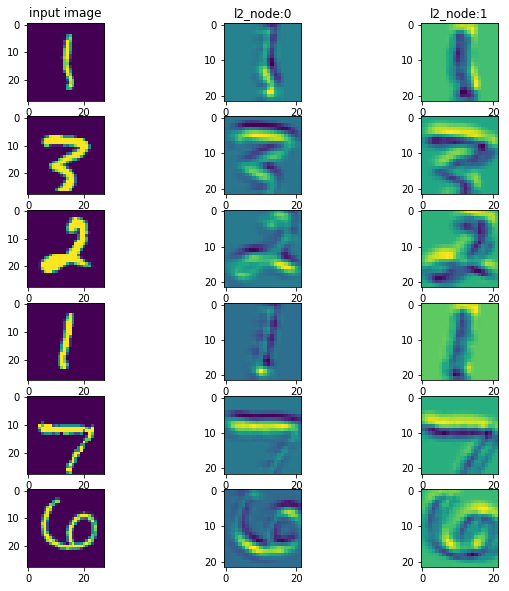

In [27]:
num_neurons2 = conv2_out.shape[1]
nrows = 6
ncols = num_neurons2+1
fig, ax = plt.subplots(figsize=(10,10), nrows = nrows, ncols = ncols )
for row_itr in range(nrows): 
    ax[row_itr, 0].imshow(img[row_itr,0])
    
    for col_itr in range(1,ncols):
        ax[row_itr, col_itr].imshow(conv2_out[row_itr,col_itr-1].numpy())
    
ax[0, 0].set_title('input image')
ax[0, 1].set_title('l2_node:{}'.format(0))
ax[0, 2].set_title('l2_node:{}'.format(1))
plt.show()  

This too looks exactly like the result we got for layer2 using hooks

## Visualizing the kernels used in the convolutional layers

To begin with let us remind ourselves what should be the shape of the weight tensor of a given convolutional layer. Let us consider the convolutional layer 
   
    nn.Conv2d(n_input, n_out, kernel_size)
    
Here, 
  - n_input = number of channels in the input to the conv. layer. If the input is an RGB image then n_input will be 3 for the three color channels in the image. However, if the input comes from an earlier conv. layer consisting of n output channel then n_input will be n
  
  
  - n_out = number of output channels of the conv. layer
  
  
  - kernel_size = the height and the width of the kernel to be applied across the 2d array in each of                   the input channels. Both of these are equal to kernel_size in the present case
  
Now, since n_out is the number of output channels, thus clearly there should be n_out sets of weight parameters. Also, different kernels will be used for each input channel and their output will be subsequently added. ( This is similar to how in a dense Neural Net. if the input is a vector of length p and there are q nodes in a given layer, then the weight tensor of this layer is a 2d matrix of shape (q,p) ). Of course for each channel, we also need to consider the height and the width of the kernel. Overall, this implies the the weight tensor of a 2d conv. layer will have shape 
   
    Shape of the weight tensor = (n_out, n_input, kernel_size, kernel_size)
    
    
In other words, the kernel corresponding to any single output channel will be of shape (n_input, kernel_size, kernel_size)

In [28]:
# example to demonstrate that the weight tensor of a conv. layer has 
# shape as described in the above text
random = nn.Conv2d(6, 2, 5 ) # creating a random instance of a 2d conv layer
random.weight.shape

torch.Size([2, 6, 5, 5])

### kernels in the first convolutional layer

In [29]:
conv1Kernel = conv1.weight.detach().clone()

In [30]:
conv1Kernel.shape

torch.Size([4, 1, 3, 3])

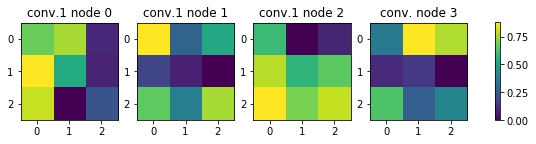

In [41]:
# there are 4 nodes and hence 4 different kernels in the 1st conv. layer
fig, ax = plt.subplots(figsize=(10,10), ncols = 4)

# we add 3 out of the 4 subplots throught the for loop below
# the last one i.e. the 4th subplot is added seperately as we use it to define a 'mappable' object
# this mappable object is needed because we need to pass it to the fig.colorbar used later to display a color-map
for idx in range(3):
    ax[idx].imshow(conv1Kernel[idx].squeeze(0))
    ax[idx].set_title('conv.{} node {}'.format(1, idx))

# use fig.colorbar to display the color map used to encode the values 
# see https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.colorbar.html
# and also https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/contour_image.html#sphx-glr-gallery-images-contours-and-fields-contour-image-py
mappable = ax[3].imshow(conv1Kernel[3].squeeze(0))
ax[3].set_title('conv. node {}'.format(3))
fig.colorbar(mappable, ax = [ax[0], ax[1], ax[2], ax[3]], shrink = 0.18) # we use shrink to scale the size of the colorbar until we get a colorbar of desired size  
plt.show()

In [32]:
from torchvision.utils import make_grid # make_grid can be used to make a single image out of multiple images
                                        # all the input images are then displayed sequentially in a single row 
                                        # the final image returned by make_grid will necessarily have 3 color channels
                                        # so if the input images were gray scale images, then the same pixel values will be 
                                        # copied to all the color channels 
                                        # Caution: The input images cannot have more than 3 channels

In [33]:
# shift the minimum to be zero
conv1Kernel = conv1Kernel - conv1Kernel.min()
# normalize the max to be 1
conv1Kernel = conv1Kernel/conv1Kernel.max()

In [34]:
conv1Kernel_im = make_grid(conv1Kernel)
conv1Kernel_im .shape # the shape of conv1Kernel can be understood as follows:
                        # the first dimension is the number of color channels which is always 3
                        # conv1Kernel can be thought to be consisting of 4 3x3 grayscale images (i.e. the 4 3x3 kernels)
                        # make_grid combines these 4 images into a single image with an interval of 2 zero-valued pixels between subsequent subimages
                        # also the final image has a border of 2 zero-valued pixels on all its sides i.e.left-end, right-end, top and bottom
                        # this implies the length of the final image array will be: 2 + 3 + 2 + 3 + 2 + 3 + 2 + 3 + 2 = 22
                        # similarly the height of the final image will be: 2 + 3 + 2 = 7
                        # the shape is (n_ColorChannels, height, length) = (3, 7, 22)

torch.Size([3, 7, 22])

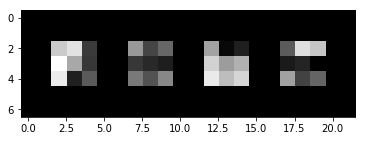

In [35]:
plt.imshow(conv1Kernel_im .permute(1,2,0)) # plt.imshow requires the color channels to the last dimension of the array
                                           # for grayscale images plt.imshow() applies a colormap to the numerical values in the image array
                                           # however conv1_im has 3 color channels and hence is not thought of as a grayscale image therefore
                                           # plt.imshow() will try to display the colors based on the input in the different colorchannels 
                                           # this is why the image displayed in the output does not have the same colors as the kernel images in the previous figure
plt.show()

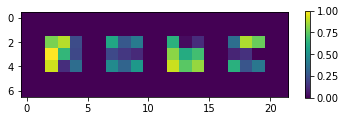

In [36]:
# plt.imshow() does apply a colorbar to the images with a single channel (as opposed to images with 3 color channels as was the case in the previous figure)
mappable2 = plt.imshow(conv1Kernel_im[0]) 
plt.colorbar(mappable2, shrink = 0.4)
plt.show()

### Kernels in the 2nd convolutional layer

In [37]:
conv2Kernel = conv2.weight.detach().clone()
conv2Kernel.shape

torch.Size([2, 4, 5, 5])

Note that the 2nd conv. layer has 2 feature maps. Each of these feature maps will have a kernel of shape 4 x 5 x 5 i.e. each kernel has 4 channels. We will display these kernels in a 2-by-4 array of plots: the rows of this plot will correspond to the feature maps in the conv. layer. The columns correspond to the 4 channels in a given kernel

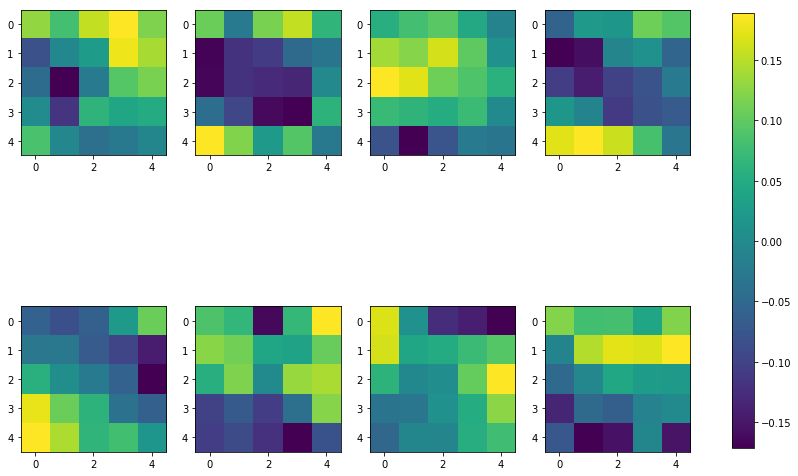

In [38]:
nrows = 2
ncols = 4
ax_list = []
fig, ax = plt.subplots(figsize= (15,10), nrows = nrows, ncols = ncols)
for row_itr in range(nrows):
    for col_itr in range(ncols):
        ax[row_itr, col_itr].imshow(conv2Kernel[row_itr, col_itr])
        ax_list.append(ax[row_itr, col_itr])
        
mappable3 = ax[1,3].imshow(conv2Kernel[1,3])  
fig.colorbar(mappable3, ax = ax_list, shrink = 0.8)
plt.show()

**NOTE: The error at the end of the following code cells is intentional**

We wish to demonstrate that, unlike in the case of conv1Kernel in the previous subsection, make_grid will not work on conv2Kernel since make_grid will interpret conv2Kernel as a set of 2 images with each image having 4 channels. However, make_grid seems to only accepts images with upto 3 color channels and therefore throws and error. 

In [39]:
# shifting the min to 0 and rescaling the max to be 1
conv2Kernel = conv2Kernel - conv2Kernel.min()/(conv2Kernel.max()-conv2Kernel.min())

In [40]:
conv2Kernel_im = make_grid(conv2Kernel)

RuntimeError: The size of tensor a (3) must match the size of tensor b (4) at non-singleton dimension 0